<a href="https://colab.research.google.com/github/yasirabd/research-diagnostic-turbine/blob/main/Prognostics_Turbine_Bearing_1_Cooling_Loss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*Create: 7 Desember 2021*<br>
*Last Update: 21 Desember 2021*<br>
*Author: Yasir Abdur Rohman*<br>
**Property of PT Indonesia Power & Lab Getaran & Diagnosis Mesin Undip**

---

# Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

In [ ]:
from scipy.spatial import distance

from sklearn.metrics import mean_squared_error

# Load Data

In [ ]:
path = "/content/drive/MyDrive/Prescriptive Maintenance/Data/Turbine Generator - SLA5/export_datasla5_01ags21-31okt21.csv"
data = pd.read_csv(path)
data.head()

,date,Generator Gross Capacity,Turbine Bearing #01 Metal Temperature,Turbine Bearing #07 X Vibration,Turbine Bearing #07 Y Vibration,Turbine Bearing #08 X Vibration,Turbine Bearing #08 Y Vibration,Turbine Bearing #09 X Vibration,Turbine Bearing #09 Y Vibration,Turbine Bearing #10 X Vibration,Turbine Bearing #10 Y Vibration,Turbine First Stage Exit Metal Temperature,Turbine Gland Steam Pressure,Turbine Gland Steam Temperature,Turbine HP Bypass Spray Valve Position,Turbine HP Bypass Valve Position,Turbine HP Casing Expansion,Turbine HP Exhaust Casing Upper Metal Temperature,Turbine HP Exhaust Steam Temperature,Turbine HP Oil Pressure,Turbine LP A Exhaust Steam Temperature,Turbine LP B Exhaust Steam Temperature,Turbine Lube Oil Cooler Inlet Temperature,Turbine Lube Oil Cooler Outlet Temperature,Turbine Lube Oil Temperature,Turbine Main Steam Casing Lower Metal Temperature,Turbine Main Steam Casing Upper Metal Temperature,Turbine Outer Casing Lower Metal Temperature,Turbine Outer Casing Upper Metal Temperature,Turbine Reheat Steam Casing Lower Metal Temperature,Turbine Reheat Steam Casing Upper Metal Temperature,Turbine.Bearing 1 Drain Oil Temperature,Turbine.Bearing 1 Metal Temperature,Turbine.Bearing 1X Vibration,Turbine.Bearing 1Y Vibration,Turbine.Bearing 2 Drain Oil Temperature,Turbine.Bearing 2 Metal Temperature,Turbine.Bearing 2X Vibration,Turbine.Bearing 2Y Vibration,Turbine.Bearing 3 Drain Oil Temperature,...,Turbine.Bearing 4X Vibration,Turbine.Bearing 4Y Vibration,Turbine.Bearing 5 Drain Oil Temperature,Turbine.Bearing 5 Metal Temperature,Turbine.Bearing 5X Vibration,Turbine.Bearing 5Y Vibration,Turbine.Bearing 6 Drain Oil Temperature,Turbine.Bearing 6 Metal Temperature,Turbine.Bearing 6X Vibration,Turbine.Bearing 6Y Vibration,Turbine.Bearing Oil Pressure,Turbine.Differential Expansion,Turbine.Eccentricity,Turbine.Final Feedwater Flow,Turbine.Final Feedwater Pressure,Turbine.Final Feedwater Temperature,Turbine.RH Spray Flow,Turbine.SH Spray Flow A,Turbine.SH Spray Flow B,Turbine.Shaft Position,Turbine.Speed,Generator Bearing #07 Metal Temperature,Generator Bearing #08 Metal Temperature,Generator Bearing #09 Metal Temperature,Generator Bearing #10 Metal Temperature,Generator.Drain Oil Temperature Bearing #07,Generator.Drain Oil Temperature Bearing #08,Generator.Drain Oil Temperature Bearing #09,Generator.Drain Oil Temperature Bearing #10,Generator.Excitation Field Current,Generator.Excitation Field Voltage,Generator.Field Current,HP Turbine.Inlet Steam Flow,HP Turbine.Inlet Steam Pressure,HP Turbine.Inlet Steam Temperature A,HP Turbine.Inlet Steam Temperature B,HP Turbine.Outlet Steam Pressure A,HP Turbine.Outlet Steam Pressure B,HP Turbine.Outlet Steam Temperature A,HP Turbine.Outlet Steam Temperature B
0,2021-10-31 23:58:00,502.852800,90.695110,0.026780,0.02,0.040791,0.048581,0.036,0.031887,0.014208,0.017453,414.565063,0.298479,149.896561,NaN,-0.001527,22.737394,330.788000,333.023468,22.00003,41.23933,40.936104,56.821785,45.442540,45.442540,362.414581,359.6599,330.621826,332.347443,406.089752,407.002167,53.905110,81.089424,0.043223,0.067297,54.590252,94.331520,0.030223,0.043336,61.412293,...,0.050872,0.048014,63.124764,87.873420,0.034554,0.015112,59.22628,79.1003,0.012096,0.014739,1.484869,13.281014,0.0,1544.68640,185.085500,274.357239,12.371912,98.934555,68.92555,-0.091122,3001.98267,63.993145,67.673440,68.443535,74.465830,57.442844,57.018997,52.042343,53.620316,33.533417,23.923126,2527.67578,1576.19763,169.058100,533.800232,540.282959,38.053234,37.958020,317.188416,323.590576
1,2021-10-31 23:57:00,503.679443,90.530716,0.026884,0.02,0.040978,0.048459,0.036,0.031065,0.014796,0.017582,414.515472,0.300081,149.868576,NaN,-0.001527,22.706820,330.738800,333.100983,22.00003,41.23933,40.916103,56.814890,45.442540,45.442540,362.514557,359.7099,330.618300,332.331600,406.110077,407.049683,53.900284,81.008640,0.043297,0.067446,54.588776,94.296875,0.029702,0.043895,61.448696,...,0.050895,0.048052,63.124764,87.882324,0.034895,0.015

In [ ]:
list(data)

['date',
 'Generator Gross Capacity',
 'Turbine Bearing #01 Metal Temperature',
 'Turbine Bearing #07 X Vibration',
 'Turbine Bearing #07 Y Vibration',
 'Turbine Bearing #08 X Vibration',
 'Turbine Bearing #08 Y Vibration',
 'Turbine Bearing #09 X Vibration',
 'Turbine Bearing #09 Y Vibration',
 'Turbine Bearing #10 X Vibration',
 'Turbine Bearing #10 Y Vibration',
 'Turbine First Stage Exit Metal Temperature',
 'Turbine Gland Steam Pressure',
 'Turbine Gland Steam Temperature',
 'Turbine HP Bypass Spray Valve Position',
 'Turbine HP Bypass Valve Position',
 'Turbine HP Casing Expansion',
 'Turbine HP Exhaust Casing Upper Metal Temperature',
 'Turbine HP Exhaust Steam Temperature',
 'Turbine HP Oil Pressure',
 'Turbine LP A Exhaust Steam Temperature',
 'Turbine LP B Exhaust Steam Temperature',
 'Turbine Lube Oil Cooler Inlet Temperature',
 'Turbine Lube Oil Cooler Outlet Temperature',
 'Turbine Lube Oil Temperature',
 'Turbine Main Steam Casing Lower Metal Temperature',
 'Turbine Main 

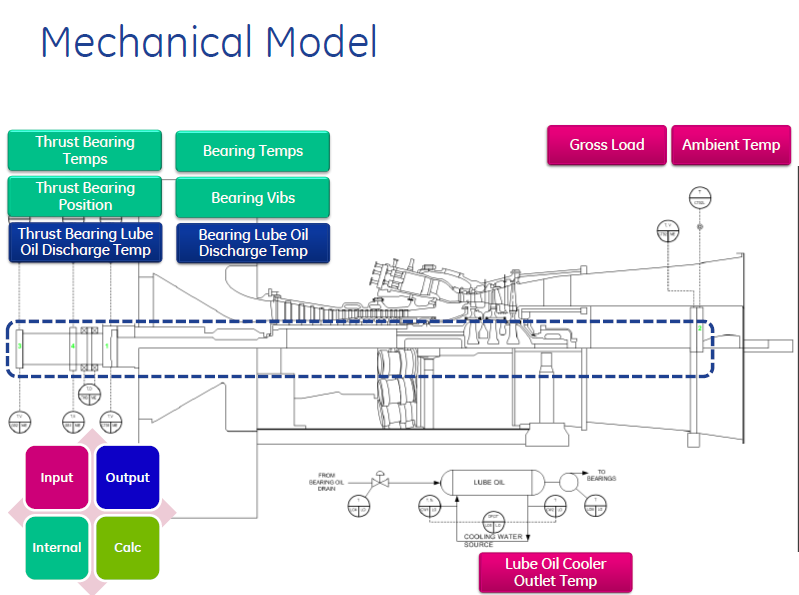

Bearing #1 sbb: 
- Gen gross capacity, 
- Turbine Lube oil cooler Outlet Temp, 
- Metal Temp (cuma ada 1; standar blueprint APM 4 per bearing) 
- Bearing oil press
- Turbine Drain oil Temp

## Problem Description

**Case:** ST Journal Bearing 1 - Cooling Loss

**Description:**

This fault indicates an abnormal change in the cooling of the supply oil to the bearings.  

Primary indicators are: 
- Journal Bearing Oil Outlet Temperature (Oil Return) is high; 
- and Bearing Metal Temperature is high.   

and 
- Priority 4 (lowest) is triggered when either Lube Oil Outlet Temperature is high or 
- Bearing Metal Temperature is high.  

The priority escalates depending on the severity of the change, and the number of sensors.  This fault triggers  Priority 2, 3 & 4.

**Input Tags:**
- LUBE_OIL_COOLER_OIL_OUTLET_TEMP
- GROSS_LOAD
- LUBE_OIL_COOLER_OIL_OUTLET_PRESS
- BRG_1_MTL_TEMP_1 
- AMBIENT_TEMP
- BRG_1_MTL_TEMP_2 
- BRG_1_MTL_TEMP_4 
- BRG_1_MTL_TEMP_3
- BRG_1_OIL_DRAIN_TEMP

**Expressions:**

```
if
    (ModelIndications(MECHANICAL,[SVH,SH,VH],[BRG_1_OIL_DRAIN_TEMP])>=1.0
    and
    ModelIndications(MECHANICAL,[SVH,SH,VH],[BRG_1_MTL_TEMP_1, BRG_1_MTL_TEMP_2, BRG_1_MTL_TEMP_3, BRG_1_MTL_TEMP_4])>=1.0)
then 
    Priority(2)
else if
    (ModelIndications(MECHANICAL,[SVH,SH,VH],[BRG_1_OIL_DRAIN_TEMP])>=1.0
    or 
        (ModelIndications(MECHANICAL,[VAR,H],[BRG_1_OIL_DRAIN_TEMP])>=1.0
        and
        ModelIndications(MECHANICAL,[VAR,H],[BRG_1_MTL_TEMP_1, BRG_1_MTL_TEMP_2, BRG_1_MTL_TEMP_3, BRG_1_MTL_TEMP_4])>=1.0))
then 
    Priority(3)
else if
    (ModelIndications(MECHANICAL,[VAR,H],[BRG_1_OIL_DRAIN_TEMP])>=1.0)
then 
    Priority(4)
else
    IsAssociated(MECHANICAL,[GROSS_LOAD,AMBIENT_TEMP,LUBE_OIL_COOLER_OIL_OUTLET_TEMP, LUBE_OIL_COOLER_OIL_OUTLET_PRESS])
```

# EDA

In [ ]:
# select tag
cols = ['Generator Gross Capacity',
        'Turbine Lube Oil Cooler Outlet Temperature',
        'Turbine Bearing #01 Metal Temperature',
        'Turbine.Bearing 1 Metal Temperature',
        'Turbine.Bearing Oil Pressure',
        'Turbine.Bearing 1 Drain Oil Temperature']

data = data[['date']+cols]

# sort by index
data = data.sort_values(by='date').reset_index(drop=True)
data.head()

,date,Generator Gross Capacity,Turbine Lube Oil Cooler Outlet Temperature,Turbine Bearing #01 Metal Temperature,Turbine.Bearing 1 Metal Temperature,Turbine.Bearing Oil Pressure,Turbine.Bearing 1 Drain Oil Temperature
0,2021-08-01 00:00:00,594.655200,46.356762,79.52576,84.711440,1.288945,51.465816
1,2021-08-01 00:01:00,587.230042,46.344955,80.16380,84.924774,1.294842,51.453390
2,2021-08-01 00:02:00,590.609131,46.331780,80.53400,84.938736,1.290403,51.440964
3,2021-08-01 00:03:00,595.542969,46.318603,80.05665,84.700806,1.292539,51.428535
4,2021-08-01 00:04:00,595.711365,46.307793,79.51846,84.569700,1.293622,51.416110


## Data Information

In [ ]:
# check data shape
data.shape

(132479, 7)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132479 entries, 0 to 132478
Data columns (total 7 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   date                                        132479 non-null  object 
 1   Generator Gross Capacity                    126142 non-null  float64
 2   Turbine Lube Oil Cooler Outlet Temperature  126110 non-null  float64
 3   Turbine Bearing #01 Metal Temperature       126145 non-null  float64
 4   Turbine.Bearing 1 Metal Temperature         126133 non-null  float64
 5   Turbine.Bearing Oil Pressure                126131 non-null  float64
 6   Turbine.Bearing 1 Drain Oil Temperature     126655 non-null  float64
dtypes: float64(6), object(1)
memory usage: 7.1+ MB


In [ ]:
# convert date to datetime
data['date'] = pd.to_datetime(data['date'])

In [ ]:
# data date
print(f"Minimum date: {data['date'].min()}")
print(f"Maximum date: {data['date'].max()}")
print(f"Interval: {data['date'][1] - data['date'][0]}")

Minimum date: 2021-08-01 00:00:00
Maximum date: 2021-10-31 23:58:00
Interval: 0 days 00:01:00


## Missing Value

In [ ]:
# check missing value
data.isnull().sum()

date                                             0
Generator Gross Capacity                      6337
Turbine Lube Oil Cooler Outlet Temperature    6369
Turbine Bearing #01 Metal Temperature         6334
Turbine.Bearing 1 Metal Temperature           6346
Turbine.Bearing Oil Pressure                  6348
Turbine.Bearing 1 Drain Oil Temperature       5824
dtype: int64

In [ ]:
# check percentage missing value
data.isnull().sum()/len(data)*100

date                                          0.000000
Generator Gross Capacity                      4.783400
Turbine Lube Oil Cooler Outlet Temperature    4.807554
Turbine Bearing #01 Metal Temperature         4.781135
Turbine.Bearing 1 Metal Temperature           4.790193
Turbine.Bearing Oil Pressure                  4.791703
Turbine.Bearing 1 Drain Oil Temperature       4.396168
dtype: float64

In [ ]:
# imputate data with interpolation
for col in cols:
    data[col] = data[col].interpolate(method='linear')

In [ ]:
data.isnull().sum()

date                                          0
Generator Gross Capacity                      0
Turbine Lube Oil Cooler Outlet Temperature    0
Turbine Bearing #01 Metal Temperature         0
Turbine.Bearing 1 Metal Temperature           0
Turbine.Bearing Oil Pressure                  0
Turbine.Bearing 1 Drain Oil Temperature       0
dtype: int64

## Descriptive Statistics

In [ ]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Generator Gross Capacity,132479.0,537.267758,138.980322,0.000000,565.072366,584.556300,589.101531,610.248900
Turbine Lube Oil Cooler Outlet Temperature,132479.0,44.676840,2.905018,32.804650,44.422540,45.485560,46.023996,47.335740
Turbine Bearing #01 Metal Temperature,132479.0,81.294799,12.418357,0.636340,82.432722,83.694840,85.358673,1268.591670
Turbine.Bearing 1 Metal Temperature,132479.0,81.662989,15.495650,-2450.339360,83.569730,84.963120,86.049395,810.952332
Turbine.Bearing Oil Pressure,132479.0,1.450022,0.084620,0.812808,1.478417,1.489524,1.496291,1.810882
Turbine.Bearing 1 Drain Oil Temperature,132479.0,52.035455,6.238847,27.052761,52.859493,53.893400,54.440229,56.443672


Mean: 537.2677576235842, Median: 584.5563


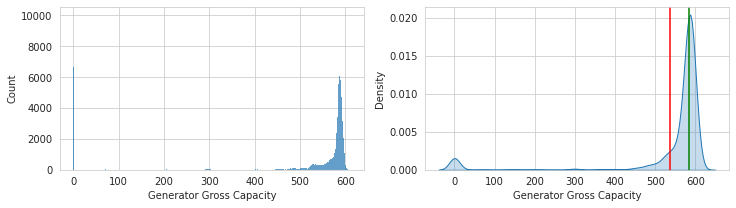

Mean: 44.67684017465912, Median: 45.48556


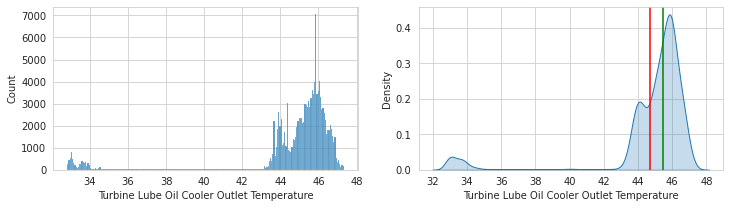

Mean: 81.2947987125137, Median: 83.69484


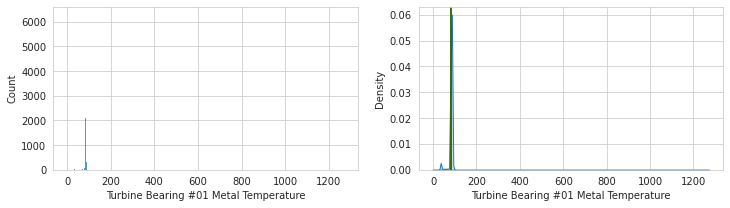

Mean: 81.66298935568848, Median: 84.96311999999999


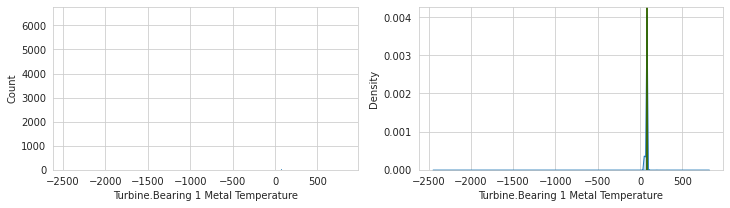

Mean: 1.450021961516848, Median: 1.48952436


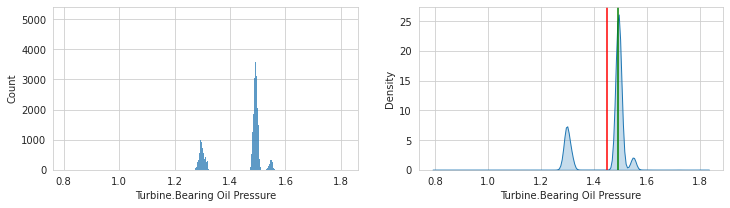

Mean: 52.0354548637803, Median: 53.8934


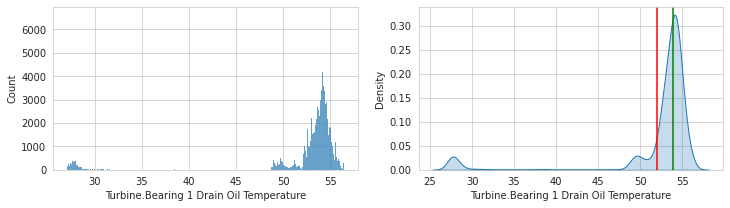

In [ ]:
# distribution
for i,col in enumerate(cols):
    fig, axes = plt.subplots(1,2,figsize=(12,3))

    # histogram plot
    sns.histplot(data=data, x=col, ax=axes[0])

    # get mean and median
    mean = data[col].mean()
    median = data[col].median()
    print(f"Mean: {mean}, Median: {median}")

    sns.kdeplot(data=data, x=col, ax=axes[1], fill=True)
    axes[1].axvline(x=mean, color='red')
    axes[1].axvline(x=median, color='green')
    plt.show();

## Plotting

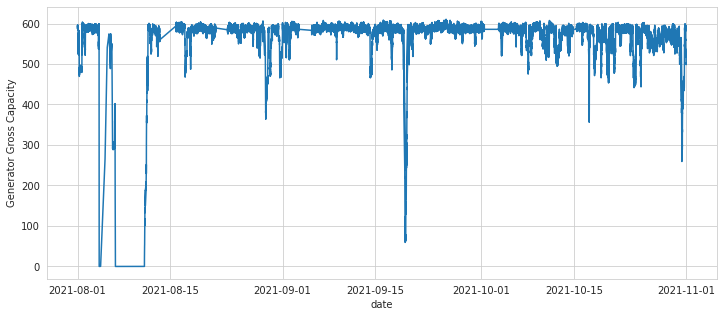

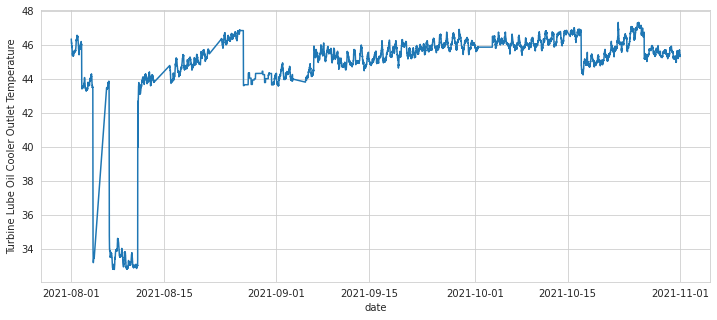

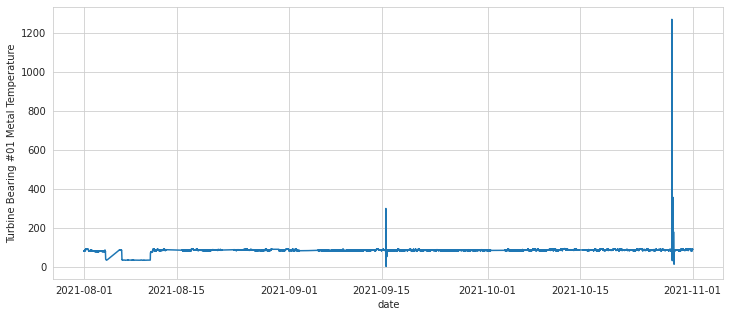

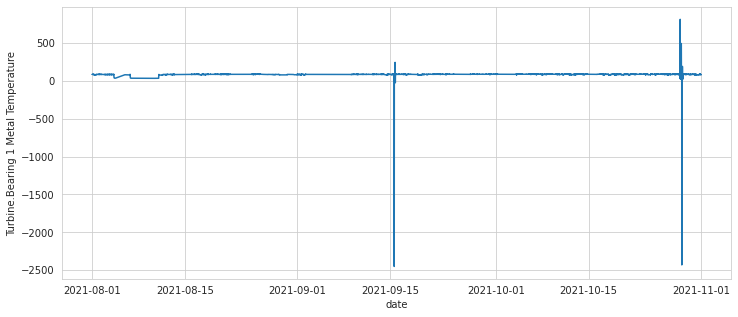

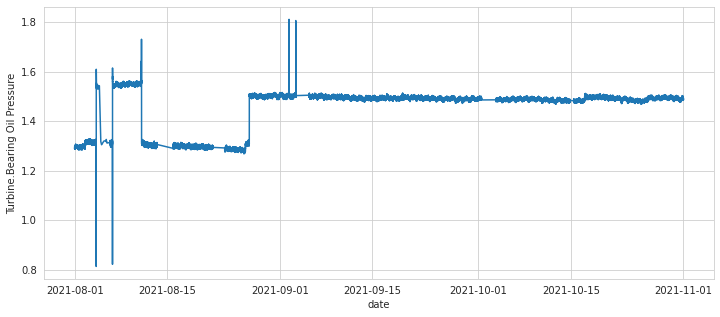

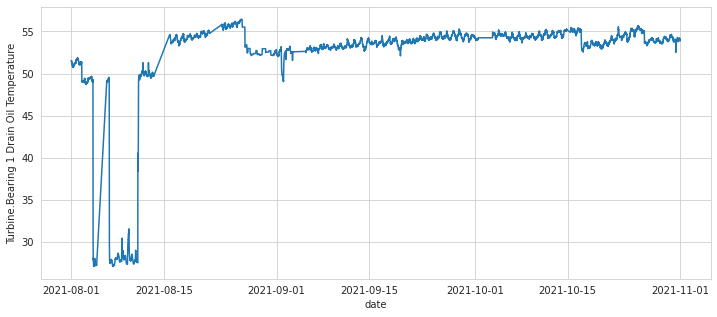

In [ ]:
for col in cols:
    plt.figure(figsize=(12,5))
    sns.lineplot(data=data, x="date", y=col)
    plt.show();

# Filter Reference Data

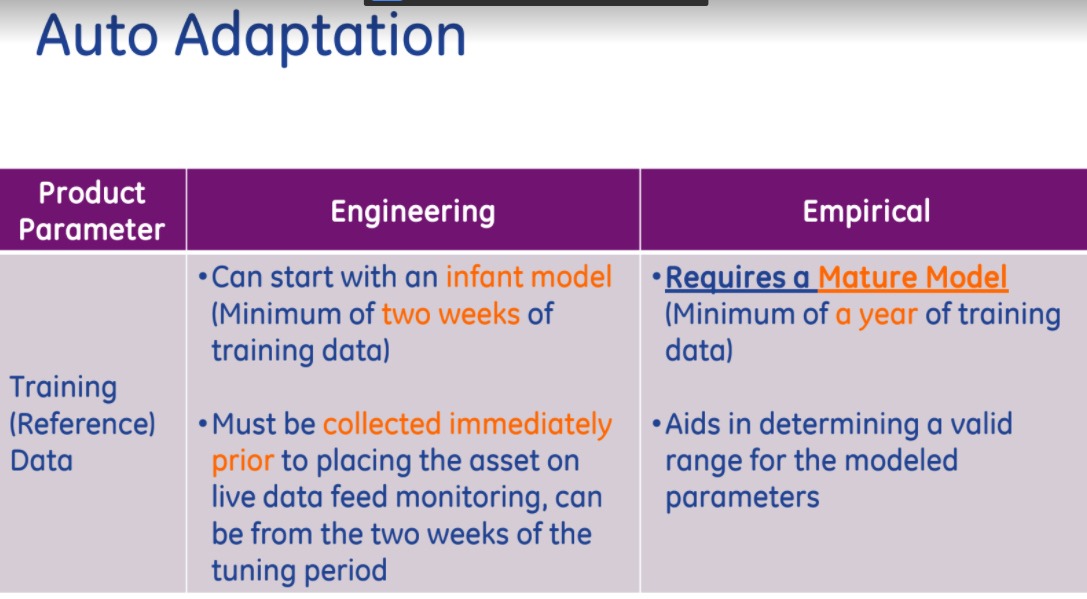

To create an **infant model**, we need at leat two weeks of training data.

## Anomaly model with machine learning

In [ ]:
data.head()

,date,Generator Gross Capacity,Turbine Lube Oil Cooler Outlet Temperature,Turbine Bearing #01 Metal Temperature,Turbine.Bearing 1 Metal Temperature,Turbine.Bearing Oil Pressure,Turbine.Bearing 1 Drain Oil Temperature
0,2021-08-01 00:00:00,594.655200,46.356762,79.52576,84.711440,1.288945,51.465816
1,2021-08-01 00:01:00,587.230042,46.344955,80.16380,84.924774,1.294842,51.453390
2,2021-08-01 00:02:00,590.609131,46.331780,80.53400,84.938736,1.290403,51.440964
3,2021-08-01 00:03:00,595.542969,46.318603,80.05665,84.700806,1.292539,51.428535
4,2021-08-01 00:04:00,595.711365,46.307793,79.51846,84.569700,1.293622,51.416110


 1    127526
-1      4953
Name: anomaly, dtype: int64


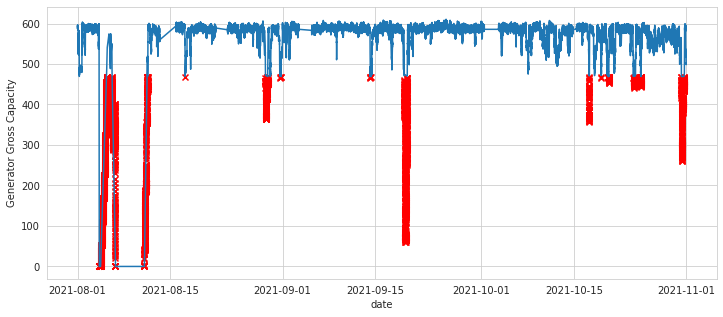

 1    121915
-1     10564
Name: anomaly, dtype: int64


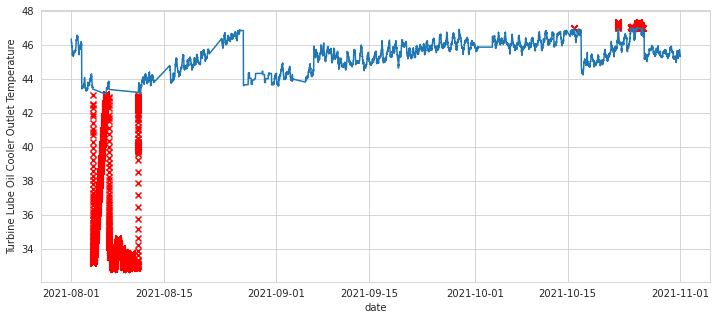

 1    122129
-1     10350
Name: anomaly, dtype: int64


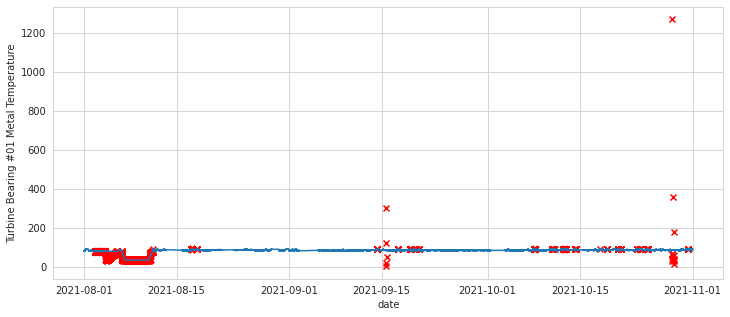

 1    121882
-1     10597
Name: anomaly, dtype: int64


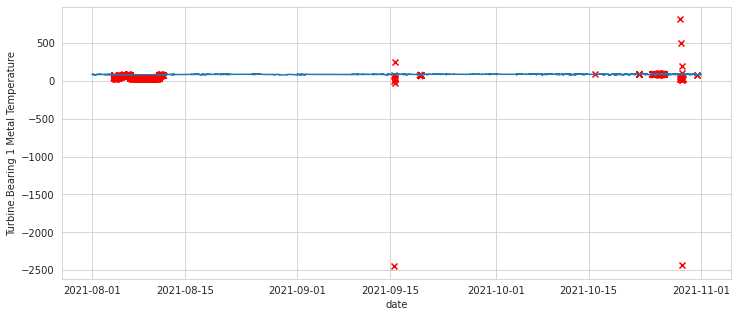

 1    121890
-1     10589
Name: anomaly, dtype: int64


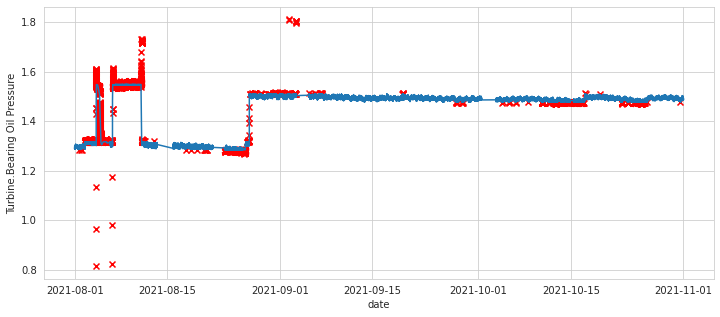

 1    121882
-1     10597
Name: anomaly, dtype: int64


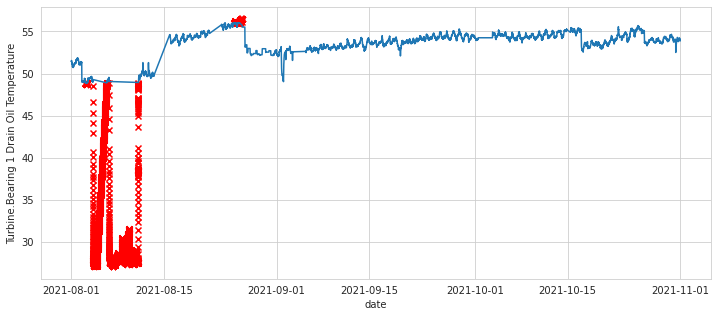

In [ ]:
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html
from sklearn.ensemble import IsolationForest
# from sklearn.svm import OneClassSVM
# from sklearn.cluster import DBSCAN
# from sklearn.preprocessing import StandardScaler


# select sensor data
X = data[cols]

# scaling
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

# univariate method IsolationForest
for col in X.columns:
    # initialize classifier
    clf = IsolationForest(random_state=2021,
                          contamination=0.08)
    
    # fit and predict
    pred = clf.fit_predict(X[col].values.reshape(-1,1))

    # plot
    df = pd.DataFrame(X[col], columns=[col])
    df['date'] = data['date']
    df['anomaly'] = pred 

    print(df['anomaly'].value_counts())

    # plotting
    inliers = df[df['anomaly'] ==  1]
    outliers = df[df['anomaly'] ==  -1]

    plt.figure(figsize=(12,5))
    plt.plot(inliers['date'], inliers[col])
    plt.scatter(x=outliers['date'], y=outliers[col], color='red', marker='x')
    plt.ylabel(col)
    plt.xlabel('date')
    plt.show();
    

# clf = DBSCAN().fit(X_scaled)
# clf = OneClassSVM(gamma="auto")

# predict
# returns -1 for outliers and 1 for inliers.
# pred_class = clf.predict(X_scaled)

# # new data
# data['anomaly'] = pred_class
# data.head()

Note:

- I tried several machine learning models; `IsolationForest`, `OneClassSVM`, and `DBSCAN` to detect anomaly/outlier but the result is still not good enough.
- For example, using `IsolationForest` to detect anomaly/outlier on `Turbine.Bearing Oil Pressure`, the result is still not good to differentiate normal or anomaly, especially on early timestamp.
- I decided to define the `threshold` manually on the next approach for better results. 

## Anomaly model with static value

If we look into GE documentation, there are two types of attributes; `runtime attributes` and `configured attributes`.

In this case, we are categorized in `configured attributes` where we need to define the value by the user (us). We could define the threshold in attribute `Actual (High)` and `Actual (Low)`.

Reference:

https://www.ge.com/digital/documentation/predix-apm/latest/smartsignal-expression-syntax.html

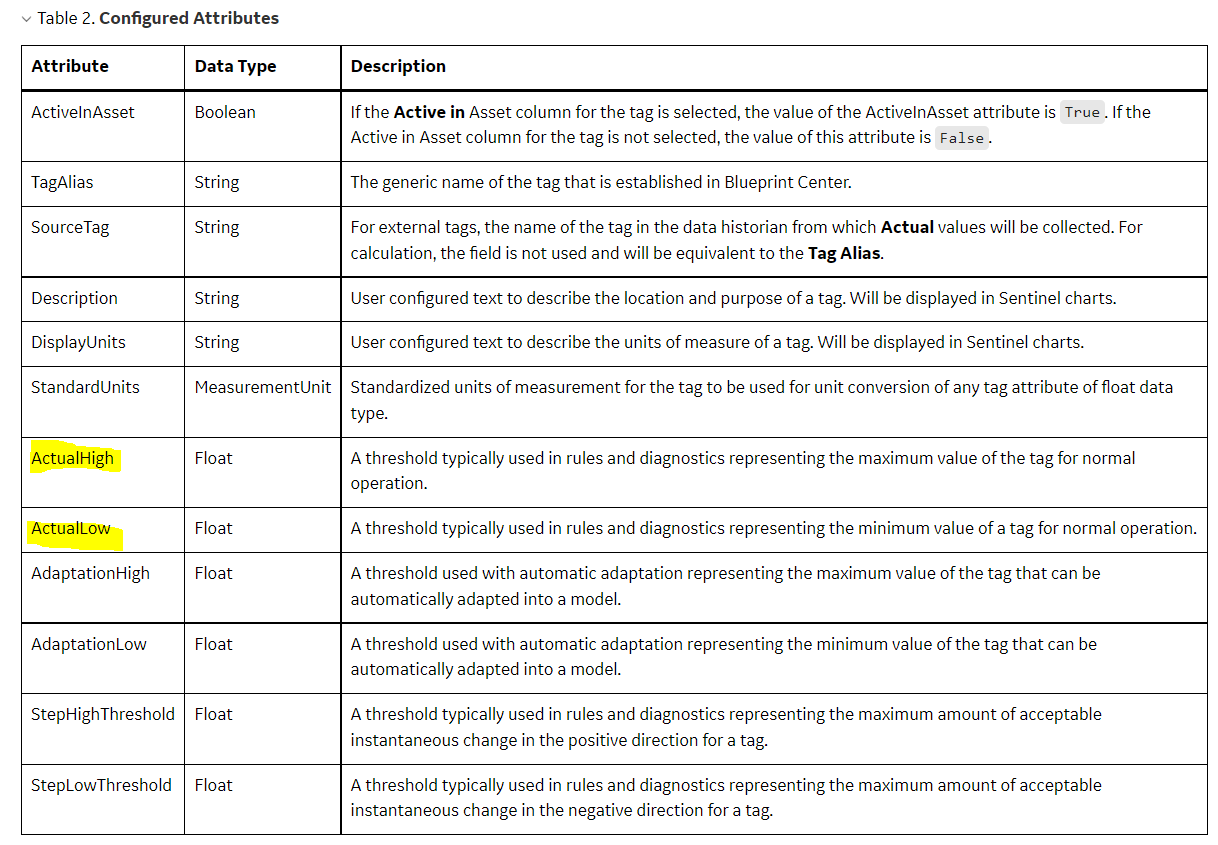

To help set the threshold, we could use `GaussianMixture` from sklearn.

In [ ]:
from sklearn.mixture import GaussianMixture

In [ ]:
list(data)

['date',
 'Generator Gross Capacity',
 'Turbine Lube Oil Cooler Outlet Temperature',
 'Turbine Bearing #01 Metal Temperature',
 'Turbine.Bearing 1 Metal Temperature',
 'Turbine.Bearing Oil Pressure',
 'Turbine.Bearing 1 Drain Oil Temperature']

### Generator Gross Capacity

In [ ]:
gross_capacity = data['Generator Gross Capacity'].values.reshape(-1,1)

gm1 = GaussianMixture(n_components=3,
                    #   init_params='random',
                    #   means_init=np.array([[100], [580]]),
                      random_state=2021).fit(gross_capacity)
pred = gm1.predict(gross_capacity)

0    92875
2    29180
1    10424
Name: class, dtype: int64


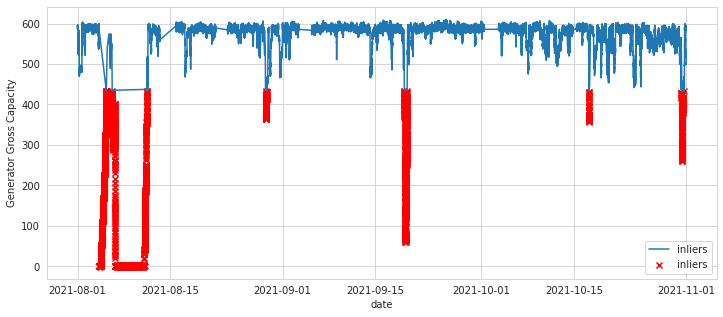

In [ ]:
df = pd.DataFrame(np.squeeze(gross_capacity), columns=['Generator Gross Capacity'])
df['date'] = data['date']
df['class'] = pred
print(df['class'].value_counts())

inliers = df[(df['class'] ==  0) | (df['class'] ==  2)]
outliers = df[df['class'] ==  1]

plt.figure(figsize=(12,5))
plt.plot(inliers['date'], inliers['Generator Gross Capacity'])
plt.scatter(x=outliers['date'], y=outliers['Generator Gross Capacity'], color='red', marker='x')
plt.ylabel('Generator Gross Capacity')
plt.xlabel('date')
plt.legend(['inliers','inliers','outliers'])
plt.show();

We use `min` and `max` of inliers as threshold.

In [ ]:
# static inliers
inliers.describe()

,Generator Gross Capacity,class
count,122055.000000,122055.000000
mean,575.562255,0.478145
std,26.177526,0.853038
min,433.783142,0.000000
25%,574.761271,0.000000
50%,585.332757,0.000000
75%,589.540150,0.000000
max,610.248900,2.000000


### Turbine Lube Oil Cooler Outlet Temperature

In [ ]:
turb_oil_temp = data['Turbine Lube Oil Cooler Outlet Temperature'].values.reshape(-1,1)

gm2 = GaussianMixture(n_components=2, random_state=2021).fit(turb_oil_temp)
pred = gm2.predict(turb_oil_temp)

0    123688
1      8791
Name: class, dtype: int64


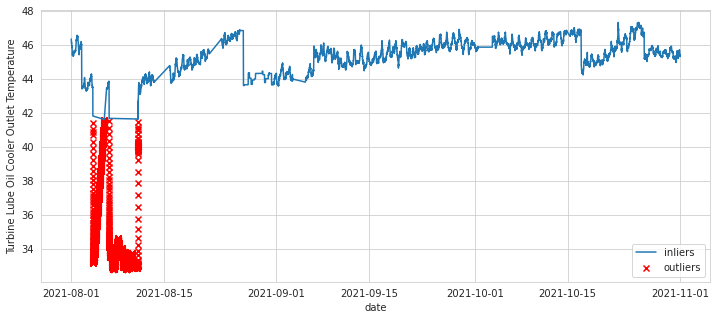

In [ ]:
df = pd.DataFrame(np.squeeze(turb_oil_temp), columns=['Turbine Lube Oil Cooler Outlet Temperature'])
df['date'] = data['date']
df['class'] = pred
print(df['class'].value_counts())

inliers = df[df['class'] ==  0]
outliers = df[df['class'] ==  1]

plt.figure(figsize=(12,5))
plt.plot(inliers['date'], inliers['Turbine Lube Oil Cooler Outlet Temperature'])
plt.scatter(x=outliers['date'], y=outliers['Turbine Lube Oil Cooler Outlet Temperature'], color='red', marker='x')
plt.ylabel('Turbine Lube Oil Cooler Outlet Temperature')
plt.xlabel('date')
plt.legend(['inliers','outliers'])
plt.show();

In [ ]:
# static inliers
inliers.describe()

,Turbine Lube Oil Cooler Outlet Temperature,class
count,123688.000000,123688.0
mean,45.397744,0.0
std,0.917852,0.0
min,41.625633,0.0
25%,44.793506,0.0
50%,45.577690,0.0
75%,46.058388,0.0
max,47.335740,0.0


### Turbine Bearing #01 Metal Temperature

In [ ]:
metal_temp_a = data['Turbine Bearing #01 Metal Temperature'].values.reshape(-1,1)

gm3 = GaussianMixture(n_components=2, random_state=2021).fit(metal_temp_a)
pred = gm3.predict(metal_temp_a)

0    123653
1      8826
Name: class, dtype: int64


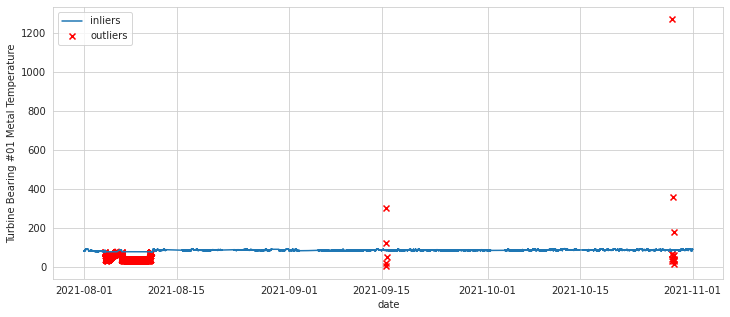

In [ ]:
df = pd.DataFrame(np.squeeze(metal_temp_a), columns=['Turbine Bearing #01 Metal Temperature'])
df['date'] = data['date']
df['class'] = pred
print(df['class'].value_counts())

inliers = df[df['class'] ==  0]
outliers = df[df['class'] ==  1]

plt.figure(figsize=(12,5))
plt.plot(inliers['date'], inliers['Turbine Bearing #01 Metal Temperature'])
plt.scatter(x=outliers['date'], y=outliers['Turbine Bearing #01 Metal Temperature'], color='red', marker='x')
plt.ylabel('Turbine Bearing #01 Metal Temperature')
plt.xlabel('date')
plt.legend(['inliers','outliers'])
plt.show();

In [ ]:
# static inliers
inliers.describe()

,Turbine Bearing #01 Metal Temperature,class
count,123653.000000,123653.0
mean,84.297110,0.0
std,2.557014,0.0
min,75.298727,0.0
25%,82.706856,0.0
50%,83.905300,0.0
75%,85.473403,0.0
max,92.167030,0.0


### Turbine.Bearing 1 Metal Temperature

In [ ]:
metal_temp_b = data['Turbine.Bearing 1 Metal Temperature'].values.reshape(-1,1)

gm4 = GaussianMixture(n_components=2, random_state=2021).fit(metal_temp_b)
pred = gm4.predict(metal_temp_b)

0    117264
1     15215
Name: class, dtype: int64


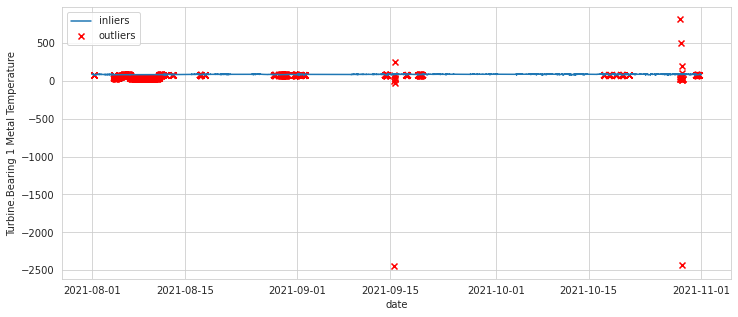

In [ ]:
df = pd.DataFrame(np.squeeze(metal_temp_b), columns=['Turbine.Bearing 1 Metal Temperature'])
df['date'] = data['date']
df['class'] = pred
print(df['class'].value_counts())

inliers = df[df['class'] ==  0]
outliers = df[df['class'] ==  1]

plt.figure(figsize=(12,5))
plt.plot(inliers['date'], inliers['Turbine.Bearing 1 Metal Temperature'])
plt.scatter(x=outliers['date'], y=outliers['Turbine.Bearing 1 Metal Temperature'], color='red', marker='x')
plt.ylabel('Turbine.Bearing 1 Metal Temperature')
plt.xlabel('date')
plt.legend(['inliers','outliers'])
plt.show();

In [ ]:
# static inliers
inliers.describe()

,Turbine.Bearing 1 Metal Temperature,class
count,117264.000000,117264.0
mean,84.977474,0.0
std,1.458390,0.0
min,80.187670,0.0
25%,84.374718,0.0
50%,85.215088,0.0
75%,86.137356,0.0
max,87.590470,0.0


### Turbine.Bearing Oil Pressure

In [ ]:
oil_press = data['Turbine.Bearing Oil Pressure'].values.reshape(-1,1)

gm5 = GaussianMixture(n_components=3, random_state=2021).fit(oil_press)
pred = gm5.predict(oil_press)

0    94463
1    30756
2     7260
Name: class, dtype: int64


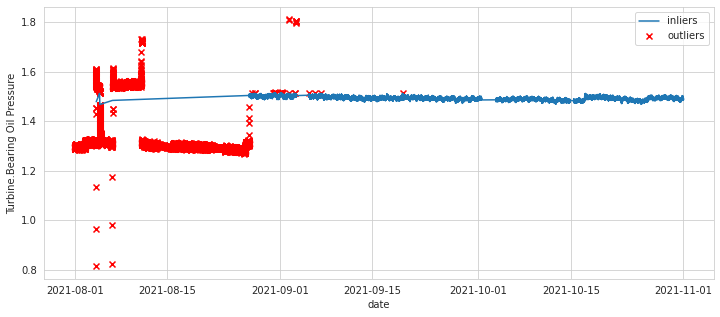

In [ ]:
df = pd.DataFrame(np.squeeze(oil_press), columns=['Turbine.Bearing Oil Pressure'])
df['date'] = data['date']
df['class'] = pred
print(df['class'].value_counts())

inliers = df[df['class'] ==  0]
outliers1 = df[df['class'] ==  1]
outliers2 = df[df['class'] ==  2]


plt.figure(figsize=(12,5))
plt.plot(inliers['date'], inliers['Turbine.Bearing Oil Pressure'])
plt.scatter(x=outliers1['date'], y=outliers1['Turbine.Bearing Oil Pressure'], color='red', marker='x')
plt.scatter(x=outliers2['date'], y=outliers2['Turbine.Bearing Oil Pressure'], color='red', marker='x')
plt.ylabel('Turbine.Bearing Oil Pressure')
plt.xlabel('date')
plt.legend(['inliers','outliers'])
plt.show();

In [ ]:
# static inliers
inliers.describe()

,Turbine.Bearing Oil Pressure,class
count,94463.000000,94463.0
mean,1.491953,0.0
std,0.007066,0.0
min,1.467023,0.0
25%,1.486639,0.0
50%,1.491924,0.0
75%,1.496861,0.0
max,1.512295,0.0


### Turbine.Bearing 1 Drain Oil Temperature

In [ ]:
oil_temp = data['Turbine.Bearing 1 Drain Oil Temperature'].values.reshape(-1,1)

gm6 = GaussianMixture(n_components=2, random_state=2021).fit(oil_temp)
pred = gm6.predict(oil_temp)

0    123312
1      9167
Name: class, dtype: int64


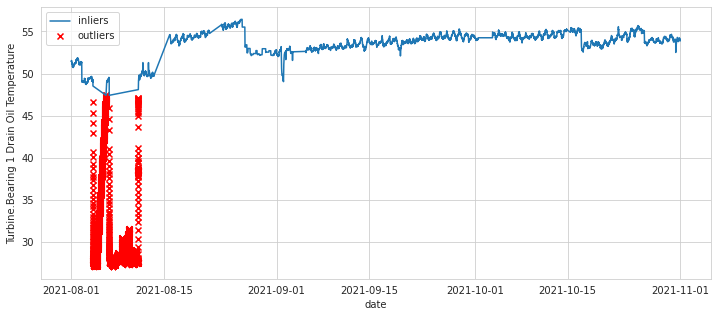

In [ ]:
df = pd.DataFrame(np.squeeze(oil_temp), columns=['Turbine.Bearing 1 Drain Oil Temperature'])
df['date'] = data['date']
df['class'] = pred
print(df['class'].value_counts())

inliers = df[df['class'] ==  0]
outliers = df[df['class'] ==  1]

plt.figure(figsize=(12,5))
plt.plot(inliers['date'], inliers['Turbine.Bearing 1 Drain Oil Temperature'])
plt.scatter(x=outliers['date'], y=outliers['Turbine.Bearing 1 Drain Oil Temperature'], color='red', marker='x')
plt.ylabel('Turbine.Bearing 1 Drain Oil Temperature')
plt.xlabel('date')
plt.legend(['inliers','outliers'])
plt.show();

In [ ]:
# static inliers
inliers.describe()

,Turbine.Bearing 1 Drain Oil Temperature,class
count,123312.000000,123312.0
mean,53.657165,0.0
std,1.409233,0.0
min,47.408993,0.0
25%,53.078632,0.0
50%,53.994045,0.0
75%,54.486519,0.0
max,56.443672,0.0


## Threshold

Based on the analysis above, we could define a dictionary for `Actual (Low)` and `Actual (High)` for each sensor.

In [ ]:
val = [[433.969025, 610.248900],
       [41.625633, 47.335740],
       [75.298727, 92.167030],
       [80.187670, 87.590470],
       [1.467023, 1.512295],
       [47.408993, 56.443672]]
threshold = pd.DataFrame(val, columns=['Actual (Low)', 'Actual (High)'], index=list(data)[1:])
threshold

,Actual (Low),Actual (High)
Generator Gross Capacity,433.969025,610.248900
Turbine Lube Oil Cooler Outlet Temperature,41.625633,47.335740
Turbine Bearing #01 Metal Temperature,75.298727,92.167030
Turbine.Bearing 1 Metal Temperature,80.187670,87.590470
Turbine.Bearing Oil Pressure,1.467023,1.512295
Turbine.Bearing 1 Drain Oil Temperature,47.408993,56.443672


## Create reference data of an infant model

Let's slice the data in the first `two weeks` as reference data to create an `infant model`.

Since data on `August` has many anomalies, we use data on `September`.

> Note: we need to check if we could make reference data with the `vector size 400`. 

In [ ]:
two_weeks = pd.to_datetime('2021-09-01 00:00:00') + pd.DateOffset(days=15)
two_weeks

Timestamp('2021-09-16 00:00:00')

In [ ]:
filter = (data['date'] >= '2021-09-01 00:00:00') & (data['date'] < two_weeks)
data_slice = data[filter].reset_index(drop=True)
data_slice.shape

(21600, 7)

In [ ]:
print(f"Minimum date: {data_slice['date'].min()}")
print(f"Maximum date: {data_slice['date'].max()}")

Minimum date: 2021-09-01 00:00:00
Maximum date: 2021-09-15 23:59:00


In [ ]:
# create state_matrix for an infant model
state_matrix = []
for i in range(len(data_slice)):

    temp = []
    for col in cols:
        actual = data_slice.loc[i,col]
        th_low = threshold.loc[col, 'Actual (Low)']
        th_high = threshold.loc[col, 'Actual (High)']

        if actual > th_low and actual < th_high:
            temp.append(actual)
        else:
            break

    if len(temp) == 6:
        state_matrix.append(np.array(temp))
    
    if len(state_matrix) == 400:
        state_matrix = np.array(state_matrix).T
        print(i)
        break

411


In [ ]:
# state matrix for an infant model
state_matrix

array([[598.481262  , 592.7966    , 596.659     , ..., 574.694641  ,
        575.5848    , 576.809265  ],
       [ 44.3122253 ,  44.3122253 ,  44.3122253 , ...,  43.6296    ,
         43.6293678 ,  43.6291847 ],
       [ 80.7649841 ,  80.61534   ,  80.648674  , ...,  84.04479   ,
         83.70082   ,  83.7140961 ],
       [ 84.11436   ,  84.07635   ,  83.99561   , ...,  83.334     ,
         83.5195    ,  83.64106   ],
       [  1.50685751,   1.50032663,   1.50034678, ...,   1.50974751,
          1.50441194,   1.50286341],
       [ 52.7968864 ,  52.7968864 ,  52.7968864 , ...,  52.12651   ,
         52.12651   ,  52.12651   ]])

In [ ]:
state_matrix.shape

(6, 400)

# Modeling

## VBM

### Create model

In [ ]:
def scipy_distance(vector1, vector2, dist='euclidean'):
    if dist == 'euclidean':
        return distance.euclidean(vector1, vector2)
    elif dist == 'braycurtis':
        return distance.braycurtis(vector1, vector2)
    elif dist == 'correlation':
        return distance.correlation(vector1, vector2)
    elif dist == 'canberra':
        return distance.canberra(vector1, vector2)
    elif dist == 'chebyshev':
        return distance.chebyshev(vector1, vector2)
    elif dist == 'cityblock':
        return distance.cityblock(vector1, vector2)
    elif dist == 'minkowski':
        return distance.minkowski(vector1, vector2)
    elif dist == 'sqeuclidean':
        return distance.sqeuclidean(vector1, vector2)
    elif dist == 'cosine':
        return distance.cosine(vector1, vector2)

In [ ]:
# function to create a dynamic matrix 
def create_dynamic_matrix(matrix, current_actual):
    
    # get current actual
    # current_actual = matrix[:, -1]

    # calculate similarity
    sim_vec = []
    for i in range(matrix.shape[1]):
        sim = 1 - scipy_distance(current_actual, matrix[:, i], dist='canberra')
        sim_vec.append(sim)
    
    # sort the matrix
    n = 10
    top = np.sort(np.array(sim_vec).argsort()[::-1][:n])
    top_sim_vec = np.array(sim_vec)[top]

    # create dynamic matrix
    dynamic_matrix = matrix[:, top]

    # calculate weight
    weight = np.array([s/np.sum(top_sim_vec) for s in top_sim_vec])

    return dynamic_matrix, weight

def vbm(dynamic_matrix, weight):
    return np.dot(dynamic_matrix, weight.T)

### Prepare data

In [ ]:
data.head()

,date,Generator Gross Capacity,Turbine Lube Oil Cooler Outlet Temperature,Turbine Bearing #01 Metal Temperature,Turbine.Bearing 1 Metal Temperature,Turbine.Bearing Oil Pressure,Turbine.Bearing 1 Drain Oil Temperature
0,2021-08-01 00:00:00,594.655200,46.356762,79.52576,84.711440,1.288945,51.465816
1,2021-08-01 00:01:00,587.230042,46.344955,80.16380,84.924774,1.294842,51.453390
2,2021-08-01 00:02:00,590.609131,46.331780,80.53400,84.938736,1.290403,51.440964
3,2021-08-01 00:03:00,595.542969,46.318603,80.05665,84.700806,1.292539,51.428535
4,2021-08-01 00:04:00,595.711365,46.307793,79.51846,84.569700,1.293622,51.416110


In [ ]:
big_matrix = data[cols].values.T
big_matrix.shape

(6, 132479)

### Predict

In [ ]:
# OLD CODE TO PREDICT/ESTIMATE

# %%time
# # Estimate t+1 sensor data
# dim_matrix = 400
# x_estimates_vbm = []
# x_actuals = []

# for i in range(big_matrix.shape[1]-dim_matrix):
#     matrix = big_matrix[:, i:i+dim_matrix]
    
#     # create dynamic matrix
#     dm, w = create_dynamic_matrix(matrix)

#     # estimate data at t+1 with input data at t
#     x_est = vbm(dm, w)

#     # get actual to calculate evaluation metric
#     x_actual = big_matrix[:, i+dim_matrix] 

#     x_estimates_vbm.append(x_est)
#     x_actuals.append(x_actual)

# # convert to numpy array
# x_estimates_vbm = np.array(x_estimates_vbm)
# x_actuals = np.array(x_actuals)

CPU times: user 29min 12s, sys: 26.3 s, total: 29min 38s
Wall time: 29min 10s


In [ ]:
%%time
# Estimate t+1 sensor data
dim_matrix = 400
x_estimates_vbm = []
x_actuals = []
state_matrix = state_matrix
th = threshold.values

for i in range(big_matrix.shape[1]):
    # CHECK IF WE NEED TO UPDATE THE STATE MATRIX
    temp = []
    # check for each sensor/tag
    for j in range(big_matrix.shape[0]):
        actual = big_matrix[j,i]
        th_low = th[j][0]
        th_high = th[j][1]

        if actual > th_low and actual < th_high:
            temp.append(actual)
        else:
            break
    # update state_matrix if all of the sensors are normal
    if len(temp) == 6:  # 6 sensors/tags
        temp = np.array(temp).reshape(-1,1)
        # insert new reference vector into
        # state matrix at the bottom or at index-400
        state_matrix = np.insert(state_matrix, [400], temp, axis=1)
        # slice state matrix to make the shape to 400
        # by removing old reference data or at index-0
        state_matrix = state_matrix[:,1:]

    # CREATE DYNAMIC MATRIX
    current_actual = big_matrix[:, i]
    dm, w = create_dynamic_matrix(state_matrix, current_actual)

    # ESTIMATE DATA t+1
    x_est = vbm(dm, w)

    # INSERT INTO LIST
    x_estimates_vbm.append(x_est)

# convert to numpy array
x_estimates_vbm = np.array(x_estimates_vbm)

CPU times: user 35min 17s, sys: 2min 16s, total: 37min 33s
Wall time: 35min 3s


### Evaluate

In [ ]:
x_actuals = data[cols].values

In [ ]:
# evaluate prognostic
print(f"MSE: {mean_squared_error(x_actuals, x_estimates_vbm)}")
print(f"RMSE: {np.sqrt(mean_squared_error(x_actuals, x_estimates_vbm))}")

MSE: 3490.167583113856
RMSE: 59.07764029744126


Generator Gross Capacity
RMSE: 143.21462271325927


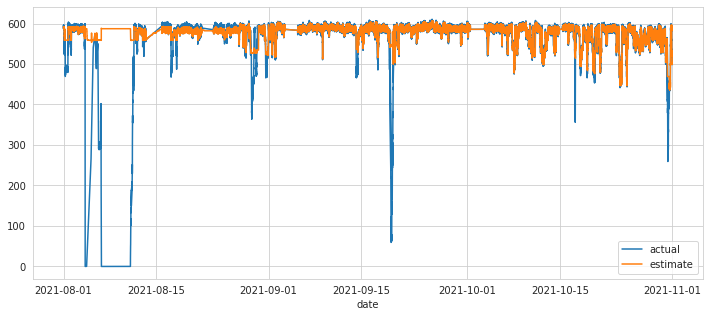

Turbine Lube Oil Cooler Outlet Temperature
RMSE: 2.502857327008282


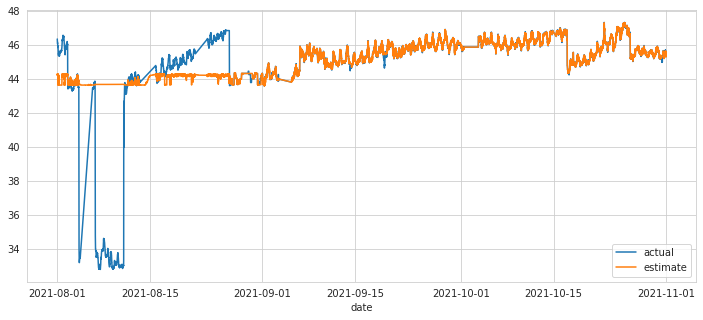

Turbine Bearing #01 Metal Temperature
RMSE: 12.122305575685033


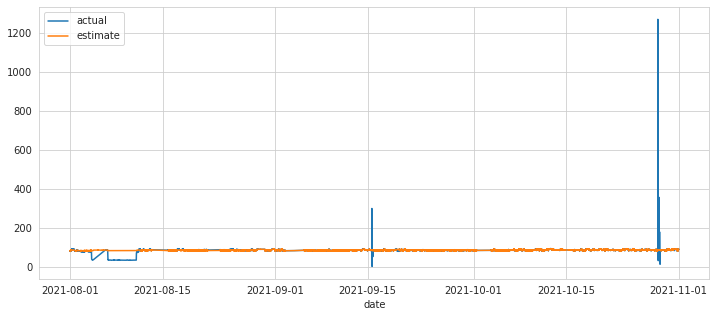

Turbine.Bearing 1 Metal Temperature
RMSE: 15.530603635433843


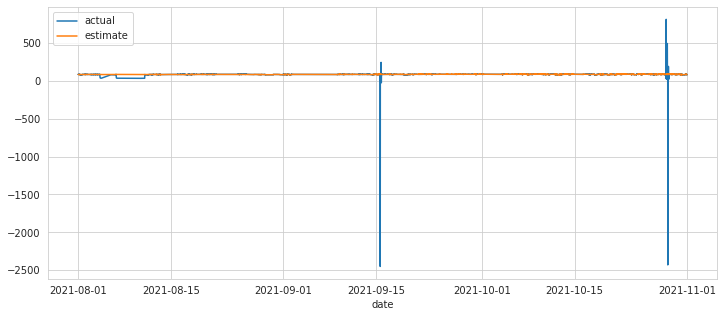

Turbine.Bearing Oil Pressure
RMSE: 0.0992879362198617


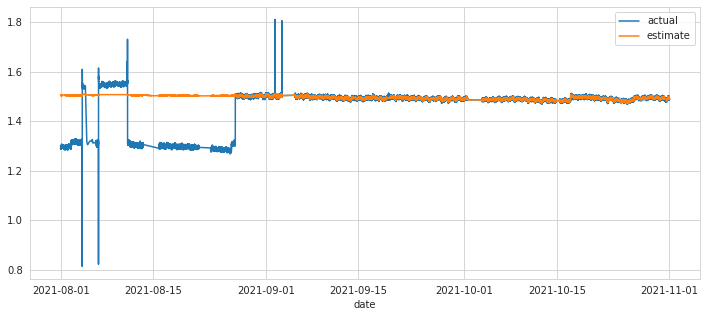

Turbine.Bearing 1 Drain Oil Temperature
RMSE: 6.012756866717086


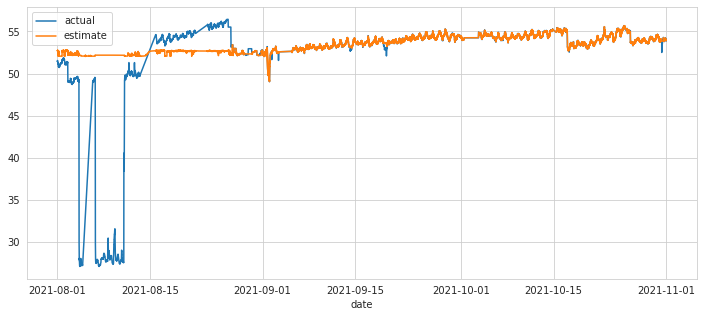

In [ ]:
# calculate RMSE for each sensor data
for i,col in enumerate(cols):
    plt.figure(figsize=(12,5))
    print(col)
    print(f"RMSE: {np.sqrt(mean_squared_error(x_actuals[:,i], x_estimates_vbm[:,i]))}")
    sns.lineplot(x=data['date'], y=x_actuals[:,i])
    sns.lineplot(x=data['date'], y=x_estimates_vbm[:,i])
    plt.legend(['actual','estimate'])
    plt.show();